In [1]:
from trdg.generators import GeneratorFromRandom
import matplotlib.pyplot as plt
import numpy as np

Missing modules for handwritten text generation.


In [10]:
def get_words(count=128):
    words = []
    for _ in range(count):
        margins = [np.random.randint(3, 8) for _ in range(4)]  # 상하좌우 각각 다른 마진 생성
        character_spacing = np.random.randint(1, 30)
        size = np.random.randint(64, 200)  # 이미지 크기를 32~200 사이에서 랜덤하게 설정
        generator = GeneratorFromRandom(
            language="cn", 
            count=2,
            background_type=0,
            fit=True,
            image_dir='./data',
            margins=tuple(margins),  # 4개의 다른 마진 값 전달
            size=size,  # 랜덤한 이미지 크기 적용
            character_spacing=character_spacing,  # 랜덤한 글자 간격 적용
            blur=3,
            random_blur=True,
            allow_variable=True,
            length=1,
            distorsion_type=1,
        )
        for _ , (patch, text) in enumerate(generator):
            words.append({"patch": patch, "text": text, "size": patch.size, "margins": margins})  # margins로 이름 변경하여 4개 값 모두 저장
    return words


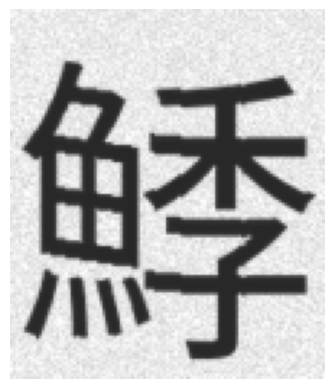

In [11]:
words = get_words(1)

plt.axis('off')
plt.imshow(words[0]['patch'])
plt.show()

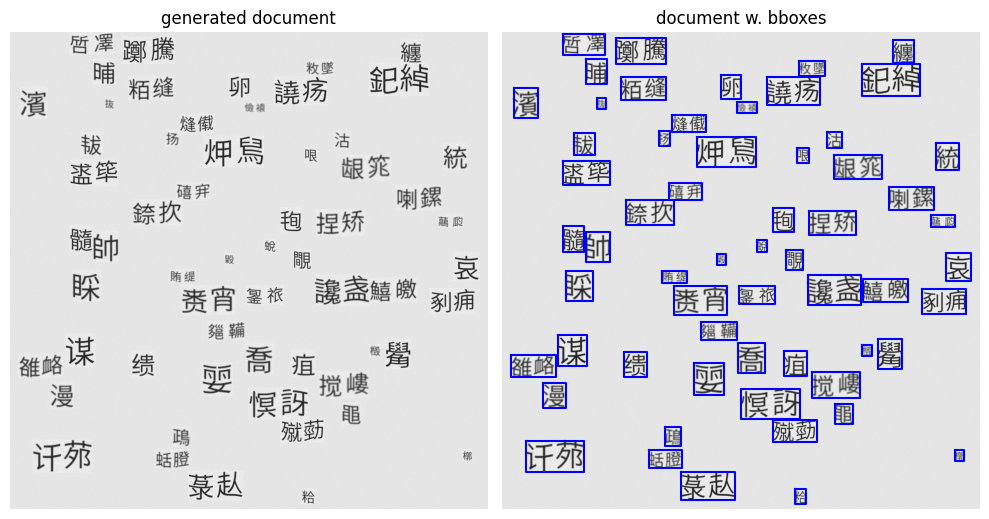

In [12]:
from synth_utils import draw_bbox, make_document
# 이번에는 좀 더 긴 문서를 만들어보겠습니다.
document = make_document(get_words(30))

plt.figure(figsize=(10,10))

# 화면 왼쪽에 생성된 문서 이미지를 출력합니다.
plt.subplot(1, 2, 1)
plt.imshow(document['image'])
plt.axis('off')
plt.title("generated document")

# 화면 오른쪽에는 문서 이미지에 bounding box를 그린 이미지를 출력합니다.
plt.subplot(1, 2, 2)
draw_bbox(document)
plt.title("document w. bboxes")

plt.tight_layout()

In [13]:
import cv2, numpy as np
from PIL import Image
from synth_utils import partial_copy, simple_shows, Document

In [14]:
your_function = cv2.getPerspectiveTransform

In [15]:
def your_vm_function(bbox: list[float], M: np.ndarray) -> np.ndarray:
    v = np.array(bbox).reshape(-1, 2).T
    v = np.vstack([v, np.ones((1, 4))])
    v = np.dot(M, v)
    v = v[:2] / v[2]
    out = v.T.flatten().tolist()
    return out

In [16]:
def perturb_document_inplace(document: Document, pad=0, color=None) -> Document:
    if color is None:
        color = [64, 64, 64]
    width, height = np.array(document["image"].size)
    magnitude_lb = 0
    magnitude_ub = 200
    src = np.array([[0, 0], [width, 0], [width, height], [0, height]], np.float32)
    perturb = np.random.uniform(magnitude_lb, magnitude_ub, (4, 2)) * np.array(
        [[1, 1], [-1, 1], [-1, -1], [1, -1]]
    )
    perturb = perturb.astype(np.float32)
    dst = src + perturb

    # obtain the transform matrix
    M = your_function(src, dst)

    # transform the image
    out = cv2.warpPerspective(
        np.array(document["image"]),
        M,
        document["image"].size,
        flags=cv2.INTER_LINEAR,
        borderValue=color,
    )
    out = Image.fromarray(out)
    document["image"] = out

    # transform the bounding boxes
    for word in document["words"]:
        bbox = word["bbox"]

        word["bbox"] = your_vm_function(bbox, M)

    return document

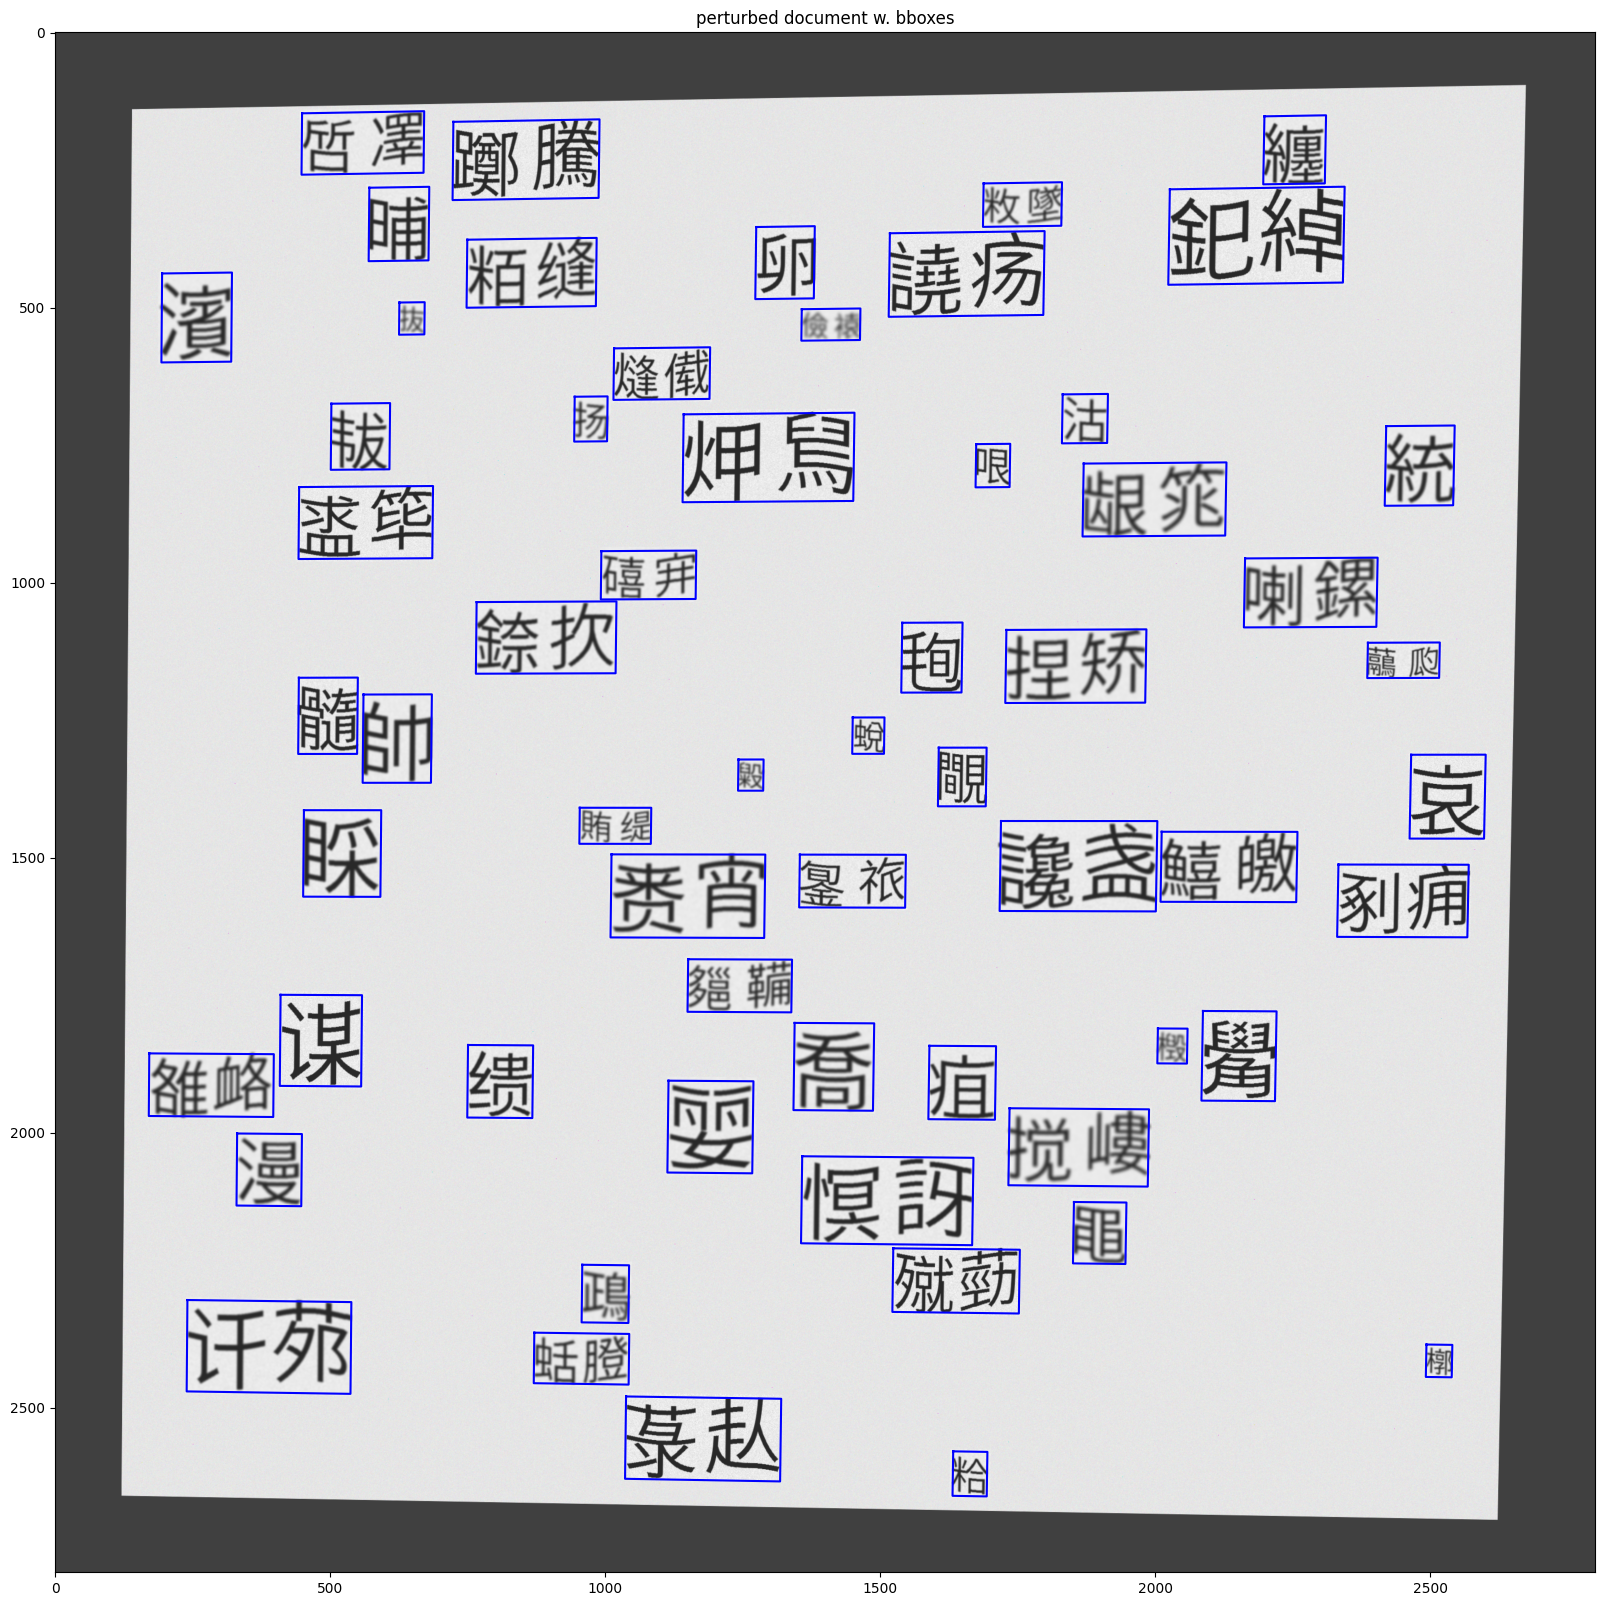

In [17]:
doc2 = partial_copy(document)
perturb_document_inplace(doc2)
plt.figure(figsize=(20,20))
plt.title("perturbed document w. bboxes")
draw_bbox(doc2)
plt.axis('on')
plt.show()